<a href="https://colab.research.google.com/github/hypro2/hands-on-LLM-from-colab/blob/main/sentence_transformers_modernbert_finetuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
!pip install -q datasets sentence_transformers faiss-cpu

In [ ]:
!pip install -q  sentence-transformers[train]==4.1.0

In [ ]:
# from datasets import load_dataset
# from datasets import Dataset

# dataset = load_dataset("csv", data_files="my_file.csv")
# # dataset = load_dataset("json", data_files="my_file.json")

# queries = []
# documents = []

# dataset = Dataset.from_dict({
#     "query": queries,
#     "document": documents,
# })


In [ ]:
from datasets import load_dataset
from sentence_transformers import SentenceTransformer
from sentence_transformers.util import mine_hard_negatives


train_dataset = load_dataset("sentence-transformers/gooaq", split="train").select(range(100))
print(train_dataset)

embedding_model = SentenceTransformer("BAAI/bge-m3", device="cuda")

In [6]:
hard_train_dataset = mine_hard_negatives(
    train_dataset,
    embedding_model,
    num_negatives=5,  # 질문-정답 쌍마다 추출할 하드 네거티브 샘플 수
    range_min=10,  # 가장 유사한 샘플 중 상위 10개는 제외
    range_max=100,  # 유사도가 높은 상위 100개 샘플까지만 고려
    max_score=0.8,  # 유사도 점수가 최대 0.8 이하인 샘플만 고려
    margin=0.1,  # 쿼리-네거티브 간 유사도는 쿼리-포지티브보다 최소 0.1 낮아야 함
    sampling_strategy="top",  # 지정된 범위 내에서 가장 유사한 것들에서 샘플링
    batch_size=4096,  # 임베딩 모델에 사용할 배치 사이즈 (4096)
    # output_format="labeled-pair",  # 출력 형식은 (query, passage, label)로 BinaryCrossEntropyLoss에서 요구됨
    use_faiss=True,  # 메모리 사용을 줄이기 위해 FAISS 사용 권장 (pip install faiss-gpu 또는 faiss-cpu 필요)
)


print(hard_train_dataset)
print(hard_train_dataset[1])

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Querying FAISS index: 100%|██████████| 1/1 [00:00<00:00, 133.33it/s]


Metric       Positive       Negative     Difference
Count             100            500               
Mean           0.6459         0.3289         0.3170
Median         0.6535         0.3338         0.3235
Std            0.0730         0.0424         0.0721
Min            0.3948         0.1959         0.1143
25%            0.6130         0.3007         0.2759
50%            0.6541         0.3338         0.3241
75%            0.6878         0.3551         0.3710
Max            0.7929         0.4200         0.4978
Skipped 71 potential negatives (0.70%) due to the margin of 0.1.
Dataset({
    features: ['question', 'answer', 'negative'],
    num_rows: 500
})
{'question': 'how to connect iphone to computer for hotspot?', 'answer': '["Go to your iPhone\'s on-screen Settings.", \'Look for Personal Hotspot; or General, followed by Network, and finally Personal Hotspot.\', \'Tap on Personal Hotspot and then slide the switch to On.\', \'Then connect the iPhone to your laptop or tablet using a

In [1]:
import logging
import traceback

import torch
from datasets import load_dataset

from sentence_transformers import SentenceTransformer
from sentence_transformers.cross_encoder import (
    CrossEncoder,
    CrossEncoderModelCardData,
    CrossEncoderTrainer,
    CrossEncoderTrainingArguments,
)
from sentence_transformers.cross_encoder.evaluation import (
    CrossEncoderNanoBEIREvaluator,
    CrossEncoderRerankingEvaluator,
)
from sentence_transformers.cross_encoder.losses.BinaryCrossEntropyLoss import BinaryCrossEntropyLoss
from sentence_transformers.evaluation.SequentialEvaluator import SequentialEvaluator
from sentence_transformers.util import mine_hard_negatives


In [2]:
model_name = "answerdotai/ModernBERT-base"

train_batch_size = 16
num_epochs = 1
num_hard_negatives = 5  # How many hard negatives should be mined for each question-answer pair

# 1a. Load a model to finetune with 1b. (Optional) model card data
model = CrossEncoder(
    model_name,
    model_card_data=CrossEncoderModelCardData(
        language="en",
        license="apache-2.0",
        model_name="ModernBERT-base trained on GooAQ",
    ),
)
print("Model max length:", model.max_length)
print("Model num labels:", model.num_labels)


config.json:   0%|          | 0.00/1.19k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/599M [00:00<?, ?B/s]

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/20.8k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.13M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/694 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/8.43k [00:00<?, ?B/s]

Model max length: 8192
Model num labels: 1


In [3]:
# 2a. Load the GooAQ dataset: https://huggingface.co/datasets/sentence-transformers/gooaq
logging.info("Read the gooaq training dataset")
full_dataset = load_dataset("sentence-transformers/gooaq", split="train").select(range(100_000))
dataset_dict = full_dataset.train_test_split(test_size=1_000, seed=12)
train_dataset = dataset_dict["train"]
eval_dataset = dataset_dict["test"]
logging.info(train_dataset)
logging.info(eval_dataset)

# 2b. Modify our training dataset to include hard negatives using a very efficient embedding model
embedding_model = SentenceTransformer("sentence-transformers/static-retrieval-mrl-en-v1", device="cpu")
hard_train_dataset = mine_hard_negatives(
    train_dataset,
    embedding_model,
    num_negatives=num_hard_negatives,  # How many negatives per question-answer pair
    margin=0,  # Similarity between query and negative samples should be x lower than query-positive similarity
    range_min=0,  # Skip the x most similar samples
    range_max=100,  # Consider only the x most similar samples
    sampling_strategy="top",  # Sample the top negatives from the range
    batch_size=4096,  # Use a batch size of 4096 for the embedding model
    output_format="labeled-pair",  # The output format is (query, passage, label), as required by BinaryCrossEntropyLoss
    use_faiss=True,
)
logging.info(hard_train_dataset)


modules.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/226 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/670k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/125M [00:00<?, ?B/s]

Batches:   0%|          | 0/21 [00:00<?, ?it/s]

Batches:   0%|          | 0/25 [00:00<?, ?it/s]

Querying FAISS index: 100%|██████████| 7/7 [05:13<00:00, 44.84s/it]


Metric       Positive       Negative     Difference
Count          99,000        479,402               
Mean           0.5882         0.5000         0.0988
Median         0.5989         0.5000         0.0610
Std            0.1425         0.1098         0.1040
Min           -0.0514         0.1552         0.0000
25%            0.4993         0.4215         0.0179
50%            0.5989         0.5000         0.0610
75%            0.6889         0.5777         0.1494
Max            0.9748         0.9508         0.7159
Skipped 878,053 potential negatives (8.78%) due to the absolute_margin of 0.
Could not find enough negatives for 15598 samples (3.15%). Consider adjusting the range_max and absolute_margin parameters if you'd like to find more valid negatives.


In [4]:
# 3. Define our training loss.
# pos_weight is recommended to be set as the ratio between positives to negatives, a.k.a. `num_hard_negatives`
loss = BinaryCrossEntropyLoss(model=model, pos_weight=torch.tensor(num_hard_negatives))

# 4a. Define evaluators. We use the CrossEncoderNanoBEIREvaluator, which is a light-weight evaluator for English reranking
nano_beir_evaluator = CrossEncoderNanoBEIREvaluator(
    dataset_names=["msmarco", "nfcorpus", "nq"],
    batch_size=train_batch_size,
)

# 4b. Define a reranking evaluator by mining hard negatives given query-answer pairs
# We include the positive answer in the list of negatives, so the evaluator can use the performance of the
# embedding model as a baseline.
hard_eval_dataset = mine_hard_negatives(
    eval_dataset,
    embedding_model,
    corpus=full_dataset["answer"],  # Use the full dataset as the corpus
    num_negatives=30,  # How many documents to rerank
    batch_size=4096,
    include_positives=True,
    output_format="n-tuple",
    use_faiss=True,
)
logging.info(hard_eval_dataset)
reranking_evaluator = CrossEncoderRerankingEvaluator(
    samples=[
        {
            "query": sample["question"],
            "positive": [sample["answer"]],
            "documents": [sample[column_name] for column_name in hard_eval_dataset.column_names[2:]],
        }
        for sample in hard_eval_dataset
    ],
    batch_size=train_batch_size,
    name="gooaq-dev",
    always_rerank_positives=False,
)

# 4c. Combine the evaluators & run the base model on them
evaluator = SequentialEvaluator([reranking_evaluator, nano_beir_evaluator])
evaluator(model)


Loading NanoBEIR datasets:   0%|          | 0/3 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/1.11M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5043 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/3.03k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/445k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Loading NanoBEIR datasets:  33%|███▎      | 1/3 [00:11<00:23, 11.89s/it]

README.md:   0%|          | 0.00/1.71k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2953 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/2.62k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/250k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Loading NanoBEIR datasets:  67%|██████▋   | 2/3 [00:24<00:12, 12.45s/it]

README.md:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/1.77M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5035 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/3.45k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


train-00000-of-00001.parquet:   0%|          | 0.00/443k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

Setting range_max to 31 based on the provided parameters.


Batches:   0%|          | 0/22 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Querying FAISS index: 100%|██████████| 1/1 [00:05<00:00,  5.06s/it]


Metric       Positive       Negative     Difference
Count           1,000         30,000               
Mean           0.5853         0.4550         0.1303
Median         0.5996         0.4488         0.1176
Std            0.1434         0.1217         0.1602
Min            0.0475         0.1611        -0.5592
25%            0.4970         0.3644         0.0149
50%            0.5996         0.4488         0.1176
75%            0.6784         0.5365         0.2318
Max            0.9532         0.9604         0.6286


W0417 01:42:46.377000 6847 torch/_inductor/utils.py:1137] [1/0] Not enough SMs to use max_autotune_gemm mode


{'gooaq-dev_map': 0.104394457909505,
 'gooaq-dev_mrr@10': 0.07096825396825396,
 'gooaq-dev_ndcg@10': 0.11927108704782699,
 'gooaq-dev_base_map': 0.5311072631437592,
 'gooaq-dev_base_mrr@10': 0.5239674603174603,
 'gooaq-dev_base_ndcg@10': 0.5912299141913906,
 'NanoMSMARCO_R100_map': 0.0317415553865647,
 'NanoMSMARCO_R100_mrr@10': 0.009714285714285713,
 'NanoMSMARCO_R100_ndcg@10': 0.02107038947802417,
 'NanoMSMARCO_R100_base_map': 0.4895766320756843,
 'NanoMSMARCO_R100_base_mrr@10': 0.4775,
 'NanoMSMARCO_R100_base_ndcg@10': 0.5404259879670522,
 'NanoNFCorpus_R100_map': 0.2549491540891856,
 'NanoNFCorpus_R100_mrr@10': 0.26804761904761903,
 'NanoNFCorpus_R100_ndcg@10': 0.19883657538726976,
 'NanoNFCorpus_R100_base_map': 0.2609949464238919,
 'NanoNFCorpus_R100_base_mrr@10': 0.49983333333333335,
 'NanoNFCorpus_R100_base_ndcg@10': 0.32504049401014556,
 'NanoNQ_R100_map': 0.046890971980732415,
 'NanoNQ_R100_mrr@10': 0.030888888888888886,
 'NanoNQ_R100_ndcg@10': 0.0465777595744788,
 'NanoNQ_R10

In [ ]:
# 5. Define the training arguments
short_model_name = model_name if "/" not in model_name else model_name.split("/")[-1]

run_name = f"reranker-{short_model_name}-gooaq-bce"

args = CrossEncoderTrainingArguments(
    # Required parameter:
    output_dir=f"models/{run_name}",
    # Optional training parameters:
    num_train_epochs=num_epochs,
    per_device_train_batch_size=train_batch_size,
    per_device_eval_batch_size=train_batch_size,
    learning_rate=2e-5,
    warmup_ratio=0.1,
    fp16=False,  # Set to False if you get an error that your GPU can't run on FP16
    bf16=True,  # Set to True if you have a GPU that supports BF16
    dataloader_num_workers=4,
    load_best_model_at_end=True,
    metric_for_best_model="eval_gooaq-dev_ndcg@10",
    # Optional tracking/debugging parameters:
    eval_strategy="steps",
    eval_steps=4000,
    save_strategy="steps",
    save_steps=4000,
    save_total_limit=2,
    logging_steps=1000,
    logging_first_step=True,
    run_name=run_name,  # Will be used in W&B if `wandb` is installed
    seed=12,
)

# 6. Create the trainer & start training
trainer = CrossEncoderTrainer(
    model=model,
    args=args,
    train_dataset=hard_train_dataset,
    loss=loss,
    evaluator=evaluator,
)
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: hyeong9647 (hyeong9647-personal) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/_inductor/compile_fx.py:1948: UserWarning: Tesla T4 does not support bfloat16 compilation natively, skipping
  warnings.warn(


Step,Training Loss,Validation Loss


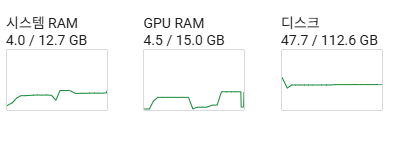

In [ ]:
# 7. Evaluate the final model, useful to include these in the model card
evaluator(model)

# 8. Save the final model
final_output_dir = f"models/{run_name}/final"
model.save_pretrained(final_output_dir)